<font color='black'><font size="4">Notebook nettoyage des données --Le plan de ce notebook (Projet 5) est le suivant:</font></font>
<font color='black'><font size="3">
* Lire le fichiers csv et le présenter sous forme d'une DataFrame
* Explication de notre stratégie
* Construire différents clusters
* Meilleur cluster construit
* Conclusion et perspectives
* Annexes -- Clustering sans Machine Learning
</font></font>  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import sklearn.metrics
import umap
import seaborn as sn
from sklearn import metrics
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import homogeneity_completeness_v_measure


pl.rcParams.update({'font.size':14})
#pip install shapely


## A) Lire le fichiers csv et le présenter sous forme d'une DataFrame

In [3]:
#data = pd.read_csv("clean_data.csv")
data_clean = pd.read_csv("data_notebook2.csv")
data = data_clean.copy()

In [3]:
data_clean.head()

,customer_unique_id,customer_zip_code_prefix,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,review_score,payment_sequential,payment_type,payment_value,product_category_name
0,23397e992b09769faf5e66f9e171a241,25931,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,8577,4,1,['credit_card'],137.58,moveis_escritorio
1,432ecfa8b7b7ad2663c7abed0dc83c51,31270,2018-04-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-03-29 07:55:24,116.99,33.08,8577,3,1,['credit_card'],150.07,moveis_escritorio
2,31318a0597cd9d50ce4cfd03c80fe780,37540,2018-03-12 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 03:47:31,106.99,21.76,8577,2,1,['boleto'],257.50,moveis_escritorio
3,acd02fc85cf6339f896c161af2b6abcd,96083,2018-03-20 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 19:54:04,106.99,38.59,8577,2,1,['credit_card'],145.58,moveis_escritorio
4,1c91f8d50340522dd6601237ad13afff,78500,2018-03-29 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-21 18:15:27,116.99,43.19,8577,4,1,['credit_card'],160.18,moveis_escritorio


<font color='darkblue'><font size="3"> 
Avant de commencer la segmentation, nous avons effectué une normalisation.
</font></font>

In [4]:
### Normaliser les variables numeriques
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_columns = data_clean.select_dtypes(exclude=['object']).columns.tolist()

data_clean[data_columns] = scaler.fit_transform(data_clean[data_columns])
data_numerical = data_clean[data_columns]
data_clean.head()


,customer_unique_id,customer_zip_code_prefix,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,review_score,payment_sequential,payment_type,payment_value,product_category_name
0,23397e992b09769faf5e66f9e171a241,0.251856,2018-03-22 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,0.015776,0.074668,0.076735,0.75,0.0,['credit_card'],0.018912,moveis_escritorio
1,432ecfa8b7b7ad2663c7abed0dc83c51,0.305798,2018-04-19 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-03-29 07:55:24,0.017262,0.080746,0.076735,0.50,0.0,['credit_card'],0.020629,moveis_escritorio
2,31318a0597cd9d50ce4cfd03c80fe780,0.369146,2018-03-12 00:00:00,0.052632,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 03:47:31,0.015776,0.053115,0.076735,0.25,0.0,['boleto'],0.035396,moveis_escritorio
3,acd02fc85cf6339f896c161af2b6abcd,0.960627,2018-03-20 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 19:54:04,0.015776,0.094195,0.076735,0.25,0.0,['credit_card'],0.020011,moveis_escritorio
4,1c91f8d50340522dd6601237ad13afff,0.782980,2018-03-29 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-21 18:15:27,0.017262,0.105424,0.076735,0.75,0.0,['credit_card'],0.022018,moveis_escritorio


In [5]:
data_clean

,customer_unique_id,customer_zip_code_prefix,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,review_score,payment_sequential,payment_type,payment_value,product_category_name
0,23397e992b09769faf5e66f9e171a241,0.251856,2018-03-22 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,0.015776,0.074668,0.076735,0.75,0.0,['credit_card'],0.018912,moveis_escritorio
1,432ecfa8b7b7ad2663c7abed0dc83c51,0.305798,2018-04-19 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-03-29 07:55:24,0.017262,0.080746,0.076735,0.50,0.0,['credit_card'],0.020629,moveis_escritorio
2,31318a0597cd9d50ce4cfd03c80fe780,0.369146,2018-03-12 00:00:00,0.052632,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 03:47:31,0.015776,0.053115,0.076735,0.25,0.0,['boleto'],0.035396,moveis_escritorio
3,acd02fc85cf6339f896c161af2b6abcd,0.960627,2018-03-20 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-13 19:54:04,0.015776,0.094195,0.076735,0.25,0.0,['credit_card'],0.020011,moveis_escritorio
4,1c91f8d50340522dd6601237ad13afff,0.782980,2018-03-29 00:00:00,0.000000,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-21 18:15:27,0.017262,0.105424,0.076735,0.75,0.0,['credit_card'],0.022018,moveis_escritorio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60899,44a269be45a77a86a2bc02877a8007e2,0.765814,2018-06-01 00:00:00,0.000000,e7d74ac41522f4ecd8782803fafc8aca,d9c349beabc06aa6ff1c6d68b5e9e22e,2018-05-08 09:30:53,0.024858,0.091657,0.026183,1.00,0.0,['credit_card'],0.028269,construcao_ferramentas_construcao
60900,38e482d7770a43f5929378c4dec76d5e,0.587490,2018-09-24 00:00:00,0.000000,c7b8e643fca22f6d8ec5f4b76b72e65f,cb810bd318f51b3dc3c753944d61a1fa,2018-08-23 15:09:48,0.259975,0.095245,0.235382,0.75,0.0,['credit_card'],0.245917,beleza_saude
60901,393c2ace23a135d0bcc7e70167448e16,0.472807,2018-08-14 00:00:00,0.000000,731cf6fbf44cc64a9583fabe2c00750e,398cb257329ef7af7f1943a8974a3cbc,2018-08-01 15:05:22,0.021559,0.037761,0.397897,1.00,0.0,['boleto'],0.022182,bebidas
60902,5c22dbb9d8b5385953f2f1e6d9d115a7,0.393192,2018-08-27 00:00:00,0.000000,a2fce4213a6ac271129618259a334261,9140ef75cc8211c4035935e80e567204,2018-08-08 18:50:15,0.007290,0.054384,0.871213,1.00,0.0,['credit_card'],0.009922,pet_shop


## B) Explication de notre stratégie

<font color='darkblue'><font size="3"> 
<b>Avant de commencer par présenter notre algorithme de clustering, nous aimerions expliquer en détail nos stratégies pour chaque clustering.</b>    
</font></font>

<font color='darkblue'><font size="3"> 
A) Commençons par présenter les différents types/critères de segmentation choisis et leurs modèles de segmentation:  
    
A-1) Un des critères les plus utilisées dans la segmentation des clients en data science est le **RFM** (Recency, Frenquency, Monetary value) où nous analysons le comportement du client, nous étudions le temps passé (nombre de jours) par an avant un autre achat, la valeur des articles achetés et le nombre total de visites.   
* Pour la segmentation RFM, nous avons appliqué les modèles de clustering (segmentation): **KMeans** et **Agglomerative**.  
    
A-2) Ensuite nous utilisons la segmentation géographique.
    
<u>*Remarque:*</u> les données fournies du client et du vendeur ne contiennent pas beaucoup d'informations sur la localisation géographique, seulement le code postal. Donc, puisque nous sommes en train d'explorer, nous allons utiliser le code postal comme emplacement géographique (pour plus de détails, allez [là](#Geo-distance) ).
* Pour la segmentation géographique, nous avons appliqué une réduction de dimension par **TSNE** sur les modèles **MiniBatchKMeans** et **Birch**.   
  
A-3) Une dernière analyse est consacrée à la segmentation psychographique, où nous recherchons le mode/besoin du client, comme le type de produit qu'il utilise.   
* Pour la segmentation psychographique, nous avons appliqué **UMAP** pour la réduction de dimensionnalité suivie par **GaussianMixture**.
    
A-4) Enfin, une segmentation démographique telle que l'âge, le revenu, le sexe, ... du client qui n'est pas réalisée dans cette étude, puisque ces informations sont confidentielles et ne sont pas fournies.
    
Nous nous basons sur l'article détaillé [sur cette page](https://www.kameleoon.com/fr/blog/segmentation-audience)
</font></font>

<font color='darkblue'><font size="3"> 
B) En data science, nous avons trouvé plusieurs avis pour évaluer le clustering, par exemple sur [cette page](https://stats.stackexchange.com/questions/268934/do-we-need-to-set-training-set-and-testing-set-for-clustering) nous avons trouvé deux avis contradictoires concerant s'il faut appliquer ou pas le train/test split sur le clustering !!!
    
Un autre point qui change d'un data scientist à l'autre est la nécessité ou pas de calculer le metrics du clustering après l'application du `cross validation` du clustering  !!    
    
Notre solution est simple, nous allons appliquer tous ces points (sans suivre un conseil spécifique ni nos avis) comme le suivant:
    
* Pour le RFM, nous utiliserons les méthodes **KMeans** et **Agglomerative**. Nous appliquerons la méthode **elbow method** au KMeans afin de savoir combien de clusters nous devons choisir, l'algorithme **Agglomerative** visualise le nombre de clusters dans un dendrogram, puis nous comparerons les deux méthodes en se basant sur le metric `silhouette_score()`!
* Pour Géographique clustering, nous utiliserons les méthodes **MiniBatchKMeans** et **Birch**. Nous divisions le dataframe en train/test, et nous comparons le deux méthodes en se basant sur `adjusted_rand_score()`, `fowlkes_mallows_score()` et `homogeneity_completeness_v_measure()`.
* Et enfin, pour psychographique clustering, nous utiliserions **GaussianMixture**. Nous appliquerons `GaussianMixture.bic` en **cross validation** pour choisir le nombre de clusters et le covariance_type. 

</font></font>

<font color='darkblue'><font size="3"> 
En résumé, le tableau ci-dessous montre la difference de statégie suivie dans cette segmentation:
</font></font>

In [6]:
pd.DataFrame(data=[['False','True','False'], ['False','True','True'],['True','False','True'],['False','True','True']], \
            index = ['train/test split','labels','cross validation','réduction dimension'],\
            columns =['RFM','Géo clustering','product clustering'])

,RFM,Géo clustering,product clustering
train/test split,False,True,False
labels,False,True,True
cross validation,True,False,True
réduction dimension,False,True,True


<font color='darkblue'><font size="3"> 
Là, tout est expliqué, nous commoncons par notre clustering, certaine points seront expliqué à la suite.
</font></font>

## C) Construire différents clusters

### C-1) RFM customer Cluster

In [7]:
from datetime import datetime
datetime_2018 = '2018-12-31 00:00:00' 
FMT = '%Y-%m-%d %H:%M:%S'

rfm_customer = data.groupby('customer_unique_id').agg({'order_estimated_delivery_date': lambda date: (datetime.strptime(datetime_2018, FMT) - datetime.strptime(date.max(), FMT)).days,
                                        'customer_unique_id': lambda num: num.value_counts(),
                                        'payment_value': lambda price: price.sum()})


In [8]:
rfm_customer.head()

,order_estimated_delivery_date,customer_unique_id,payment_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,224,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,230,1,27.19
0004bd2a26a76fe21f786e4fbd80607f,256,1,166.98
00050ab1314c0e55a6ca13cf7181fecf,236,1,35.38
00053a61a98854899e70ed204dd4bafe,280,2,838.36


#### C-1-1) Clustering by KNN

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(rfm_customer)
customers_normalized = scaler.transform(rfm_customer)

<font color='darkblue'><font size="3"> 
Afin de choisir le nombre de cluster pour le KMeans nous utiliserons '**Elbow method**' pour calculer le SSE (sum of squared errors).
    
Si le graphique linéaire ressemble à un bras, alors le "coude/elbow" du bras est la valeur de k qui est la meilleure. Notre objectif est donc de choisir une petite valeur de k qui a toujours une faible SSE, et le coude représente généralement l'endroit où nous commençons à avoir des rendements décroissants en augmentant k.    
</font></font>

In [10]:
import seaborn as sn
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

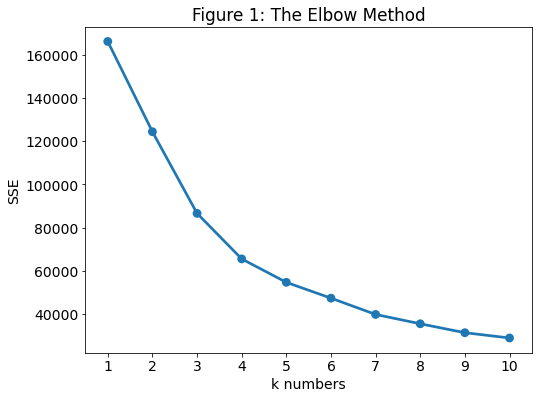

In [11]:
pl.figure(figsize=(8,6))
pl.title('Figure 1: The Elbow Method')
pl.xlabel('k numbers')
pl.ylabel('SSE')
sn.pointplot(x=list(sse.keys()), y=list(sse.values()))
pl.show()

<font color='darkblue'><font size="3"> 
Nous remarquons que pour k=4, nous avons la forme du coude du bras.
</font></font>

In [12]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(55476,)

Text(0.5, 1.0, 'Figure 2: Snake plot RFM n=4, Cluster KMeans')

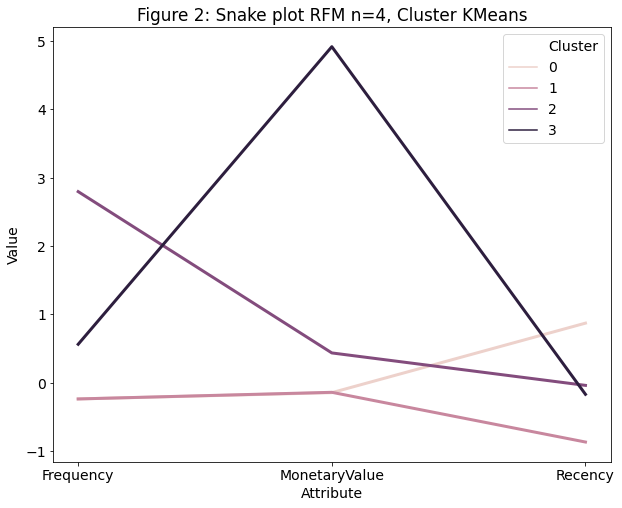

In [13]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = data_clean['customer_unique_id']
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
pl.figure(figsize=(10,8))
sn.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt, linewidth=3, ci=None, legend ='full') 
pl.title('Figure 2: Snake plot RFM n=4, Cluster KMeans')

<font color='darkblue'><font size="3"> 
Ce graphique ne ressemble pas au graphique de clustering que nous voyons habituellement. Nous avons décidé de présenter chaque variable de RFM afin de mieux l'analyser.
</font></font>

#### C-1-2) Clustering by Agglomerative

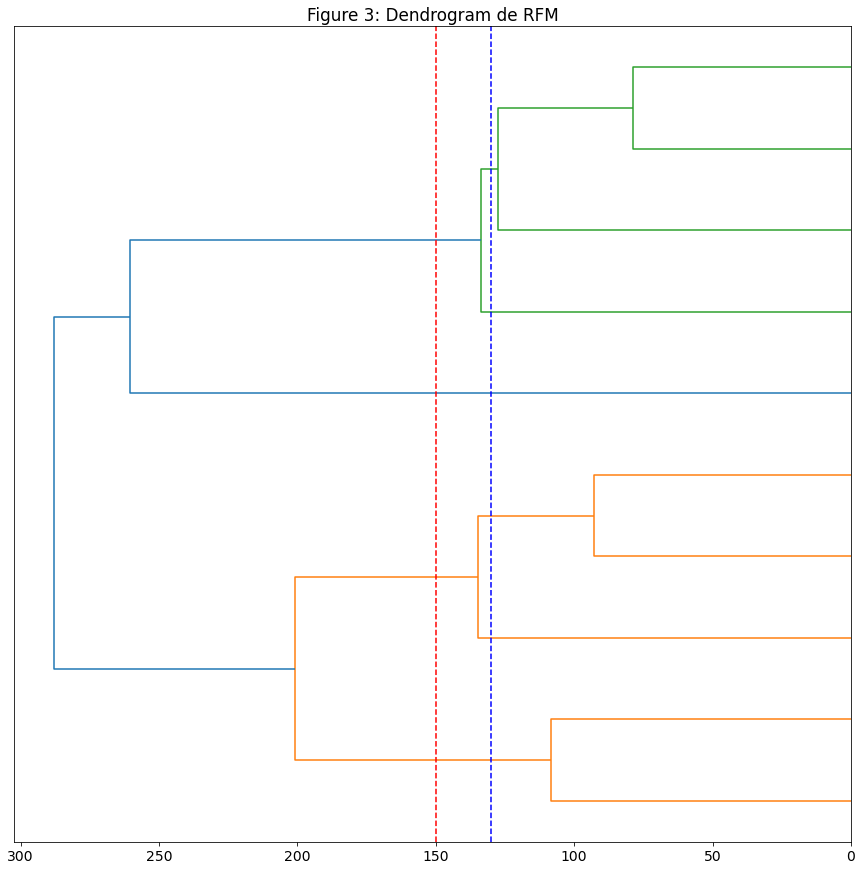

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
#X = rfm_customer[['order_estimated_delivery_date','customer_unique_id','payment_value']].values
X =  customers_normalized.copy()
linked = linkage(X,'ward')

pl.figure(figsize=(15, 15))
dendrogram(linked, p=10,
        truncate_mode='lastp',
        orientation='left',
        distance_sort='descending',
        show_leaf_counts=False)

pl.axvline(x=150, color='r', linestyle='--')
pl.axvline(x=130, color='b', linestyle='--')
pl.title('Figure 3: Dendrogram de RFM')
pl.show()

<font color='darkblue'><font size="3"> Nous avons différents choix du numéro de clusters. Nous avons choisi **n-clusters = 4** et **n-clusters = 6**.
</font></font>

In [38]:
## n_clusters = 4
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
cluster.fit(X)

AgglomerativeClustering(n_clusters=4)

Text(0.5, 1.0, 'Figure 5: Snake plot RFM n=4, Cluster agglomerative')

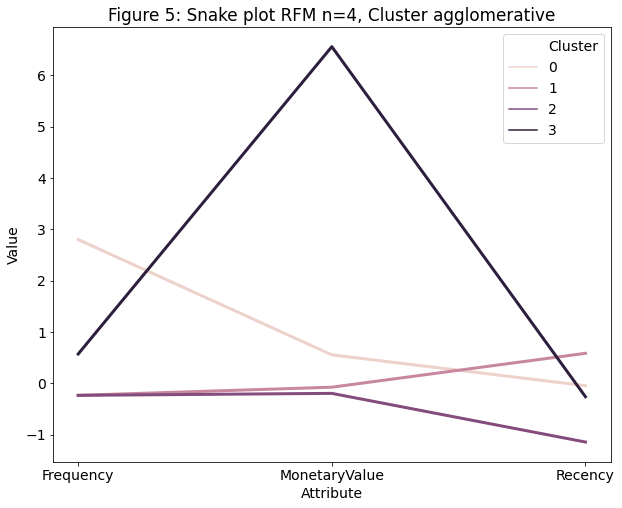

In [39]:
# Create the dataframe
df_normalized_cluster = pd.DataFrame(X, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized_cluster['ID'] = data_clean['customer_unique_id']
df_normalized_cluster['Cluster'] = cluster.labels_
rfm_customer["4-Cluster_agglomerative"] = cluster.labels_
# Melt The Data
df_nor_melt_cluster = pd.melt(df_normalized_cluster.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt_cluster.head()
# Visualize it
pl.figure(figsize=(10,8))
sn.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt_cluster, linewidth=3, ci=None, legend='full') 
pl.title('Figure 5: Snake plot RFM n=4, Cluster agglomerative')

<font color='darkblue'><font size="3"> 
Le graphique de l'Agglomerative n-clusters = 4 est presque le même que celui de KMeans.
</font></font>

In [40]:
## n_clusters=6
from sklearn.cluster import AgglomerativeClustering

cluster_6 = AgglomerativeClustering(n_clusters=6, linkage='ward')
cluster_6.fit(X)

# Create the dataframe
df_normalized_cluster_6 = pd.DataFrame(X, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized_cluster_6['ID'] = data_clean['customer_unique_id']
df_normalized_cluster_6['Cluster'] = cluster_6.labels_
rfm_customer["6-Cluster_agglomerative"] = cluster_6.labels_
# Melt The Data
df_nor_melt_cluster_6 = pd.melt(df_normalized_cluster_6.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt_cluster_6.head()

,ID,Cluster,Attribute,Value
0,23397e992b09769faf5e66f9e171a241,0,Recency,-0.121064
1,432ecfa8b7b7ad2663c7abed0dc83c51,0,Recency,-0.039268
2,31318a0597cd9d50ce4cfd03c80fe780,0,Recency,0.315182
3,acd02fc85cf6339f896c161af2b6abcd,0,Recency,0.042528
4,1c91f8d50340522dd6601237ad13afff,3,Recency,0.642367


Text(0.5, 1.0, 'Figure 6: Snake plot RFM n=6, Cluster agglomerative')

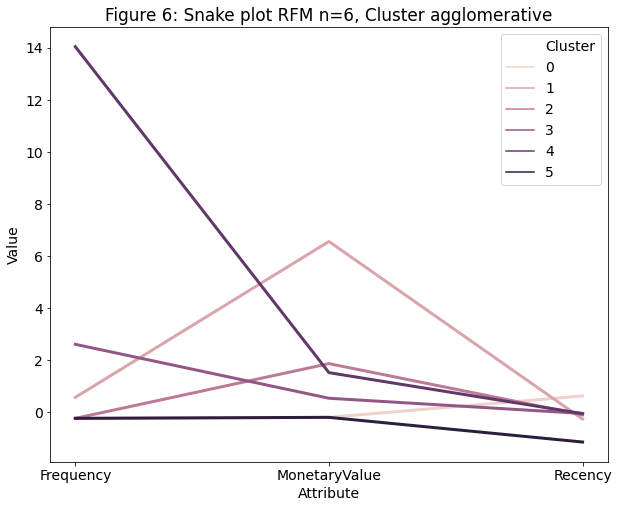

In [41]:
# Visualize it
pl.figure(figsize=(10,8))
sn.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt_cluster_6, linewidth=3, ci=None, legend = 'full')
pl.title('Figure 6: Snake plot RFM n=6, Cluster agglomerative')

<font color='darkblue'><font size="3"> 
Pour n-cluster = 6, nous trouvons un nouveau groupe d'anciens clients fidèles mais qui ont cessé de l'être depuis, et un autre groupe de clients qui dépensent de grosses sommes d'argent mais n'ont pas acheté récemment.
</font></font>

#### C-1-3) Comparaison RFM 

In [59]:
SS_4Means = silhouette_score(customers_normalized, model.labels_, metric='euclidean')
SS_6agglomerative = silhouette_score(customers_normalized, rfm_customer["6-Cluster_agglomerative"], metric='euclidean')
SS_4agglomerative = silhouette_score(customers_normalized, rfm_customer["4-Cluster_agglomerative"], metric='euclidean')

CH_4Means = metrics.calinski_harabasz_score(customers_normalized, model.labels_)
CH_6agglomerative = metrics.calinski_harabasz_score(customers_normalized, rfm_customer["6-Cluster_agglomerative"])
CH_4agglomerative = metrics.calinski_harabasz_score(customers_normalized, rfm_customer["4-Cluster_agglomerative"])

DB_4Means = davies_bouldin_score(customers_normalized, model.labels_)
DB_6agglomerative = davies_bouldin_score(customers_normalized, rfm_customer["6-Cluster_agglomerative"])
DB_4agglomerative = davies_bouldin_score(customers_normalized, rfm_customer["4-Cluster_agglomerative"])

In [64]:
RFM_table = pd.DataFrame(np.column_stack([[SS_4Means, DB_4Means, CH_4Means], [SS_4agglomerative, DB_4agglomerative, CH_4agglomerative], [SS_6agglomerative, DB_6agglomerative, CH_6agglomerative] ]), columns=['RFM-4Means','RFM-4Agglom','RFM-6Agglom'], index=['Silhouette Score', 'Davies Bouldin', 'Calinski Harabasz Score'])

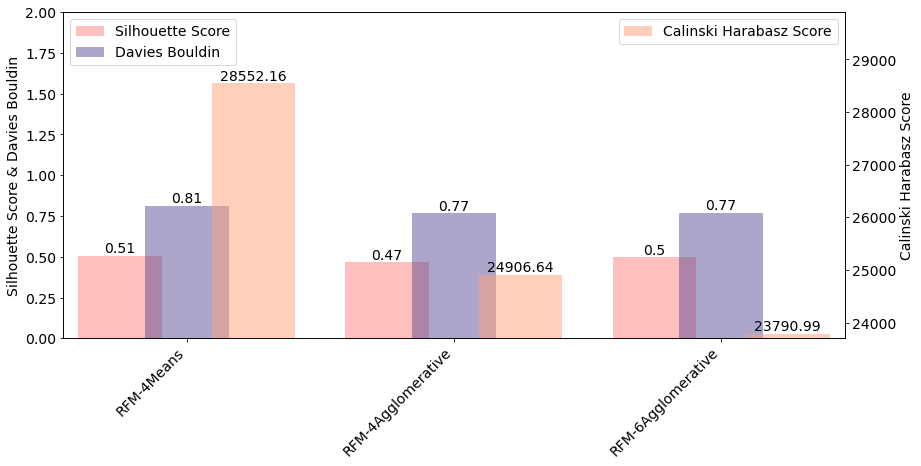

In [162]:
pl.figure(figsize=(14,6))
ax1 = pl.subplot(111)
ax1.margins(0.02, 0.1) 
ax1.set_ylabel('Silhouette Score & Davies Bouldin')
x1, x2 , x3 =[0,0.8,1.6], [0.2,1,1.8],[0.4,1.2,2]

labels = ['RFM-4Means','RFM-4Agglomerative', 'RFM-6Agglomerative']
pl.xticks([0.2,1,1.8],labels,rotation=45,ha='right')
ax2 = ax1.twinx()
ax2.set_ylabel('Calinski Harabasz Score')

ax1.bar(x1, RFM_table.loc['Silhouette Score'], width = 0.25, alpha= 0.25, color ='r', align = 'center')
ax1.bar(x2, RFM_table.loc['Davies Bouldin'], width = 0.25, alpha = 0.45, color='darkslateblue', align = 'center')
ax2.bar(x3, RFM_table.loc['Calinski Harabasz Score'], width = 0.25, alpha= 0.5, color ='lightsalmon', align = 'center')

ax1.set_ylim(0,2)
ax2.set_ylim(23700,29900)

ax1.legend(['Silhouette Score','Davies Bouldin'], loc = 'upper left')
ax2.legend(['Calinski Harabasz Score'], loc = 'upper right')

total_LR = len(RFM_table.loc['Silhouette Score'])
for p in np.arange(0,len(RFM_table.loc['Silhouette Score'])):
    ax1.annotate(str(np.round(RFM_table.loc['Silhouette Score'][p],2)), xy=(x1[p],RFM_table.loc['Silhouette Score'][p]), ha='center', va='bottom')
    ax1.annotate(str(np.round(RFM_table.loc['Davies Bouldin'][p],2)), xy=(x2[p],RFM_table.loc['Davies Bouldin'][p]), ha='center', va='bottom')
    ax2.annotate(str(np.round(RFM_table.loc['Calinski Harabasz Score'][p],2)), xy=(x3[p],RFM_table.loc['Calinski Harabasz Score'][p]), ha='center', va='bottom')
    
pl.show()

<a id='Geo-distance'></a>
## C-2) Geo-distance Cluster

<font color='darkblue'><font size="3"> 
Un calcul symbolique de la distance entre l'emplacement géographique du client et le vendeur.
C'est une méthode rudimentaire vue la manque des coordonées géographiques.
</font></font>

In [6]:
data_numerical.head()
data_numerical['distance'] = np.sqrt((data_numerical['customer_zip_code_prefix']-data_numerical['seller_zip_code_prefix'])**2)

<ipython-input-6-ecdfa8d107fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numerical['distance'] = np.sqrt((data_numerical['customer_zip_code_prefix']-data_numerical['seller_zip_code_prefix'])**2)


In [7]:
data_numerical.drop(columns=['customer_zip_code_prefix','seller_zip_code_prefix'], inplace=True)

C:\Users\Rouba\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
data_train = data_numerical.sample(frac=0.5)
data_test = data_numerical.drop(data_train.index, axis=0)

In [9]:
X_train = data_train.drop(columns=['distance'])
y_train = data_train['distance']

X_test = data_test.drop(columns=['distance'])
y_test = data_test['distance']

#### C-2-1) Réduction dimensionnelle par TSNE

In [10]:
from sklearn.manifold import TSNE
tsne_em = TSNE().fit_transform(X_train)
tsne_em = pd.DataFrame(tsne_em)
tsne_test = TSNE().fit_transform(X_test)
tsne_test = pd.DataFrame(tsne_test)

#### C-2-2) Clustering MiniBatch 

In [11]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=17, random_state=42,batch_size=100,max_iter=300)
kmeans.fit(tsne_em)
kmeans.predict(tsne_test)
y_pred_mini = kmeans.labels_

In [13]:
RI_Mini = metrics.adjusted_rand_score(y_test, y_pred_mini)

FK_Mini = metrics.cluster.fowlkes_mallows_score(y_test, y_pred_mini)

HCV_Mini = metrics.homogeneity_completeness_v_measure(y_test, y_pred_mini)

Text(0.5, 1.0, 'Figure 7: TSNE géographique par segmentation Mini Batch KMeans')

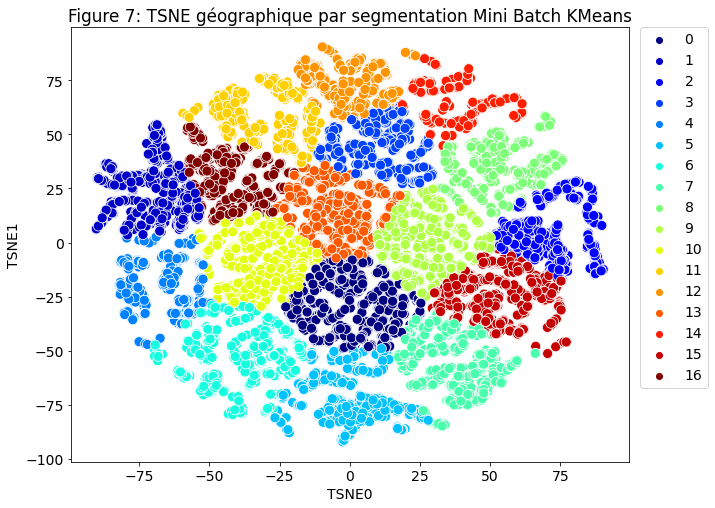

In [14]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
sn.mpl_palette("jet", 6)
sn.scatterplot(x=tsne_em[0], y=tsne_em[1], hue=y_pred_mini, legend="full", palette="jet", s=100)
pl.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

pl.xlabel('TSNE0')
pl.ylabel('TSNE1')
pl.title('Figure 7: TSNE géographique par segmentation Mini Batch KMeans')

#### C-2-3) Clustering Birch 

In [15]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=17, threshold=0.1)
brc.fit(tsne_em)
brc.predict(tsne_test)
y_pred_brc = brc.labels_

In [16]:
RI_Birch = metrics.adjusted_rand_score(y_test, y_pred_brc)

FK_Birch = metrics.cluster.fowlkes_mallows_score(y_test, y_pred_brc)

HCV_Birch = metrics.homogeneity_completeness_v_measure(y_test, y_pred_brc)

Text(0.5, 1.0, 'Figure 8: TSNE géographique par segmentation Birch')

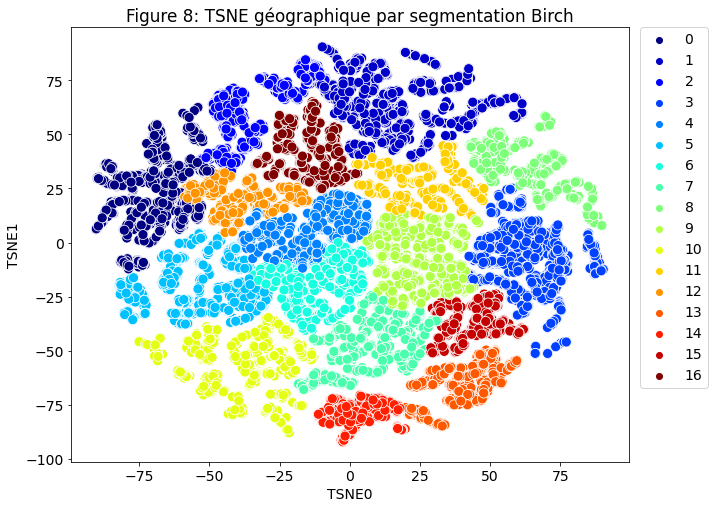

In [17]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
sn.mpl_palette("jet", 6)
sn.scatterplot(x=tsne_em[0], y=tsne_em[1], hue=y_pred_brc, legend="full", palette="jet", s=100)
pl.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

pl.xlabel('TSNE0')
pl.ylabel('TSNE1')
pl.title('Figure 8: TSNE géographique par segmentation Birch')

#### C-2-4) Comparaison clustering géographique 

In [19]:
pd.DataFrame(np.column_stack([HCV_Birch, HCV_Mini]), columns=['BIRCH','Mini-KMeans'], index=['homogeneity','completeness','v_measure'])

,BIRCH,Mini-KMeans
homogeneity,0.264628,0.267525
completeness,0.973959,0.974244
v_measure,0.416179,0.419780


#### C-2-5) Analyse
<font color='darkblue'><font size="3"> 
Dans cette partie, il est un peu difficile de faire une analyse des clients puisque nous avons fait une réduction de la dimension. Cette partie est utilisée uniquement pour faire du clustering sans dire quel client nous devrions cibler pour la proposition de contrat de maintenance. 
Maintenant, nous pouvons creuser un peu plus loin et compter les valeurs dans chaque cluster, choisir celui qui a le plus de valeurs et rechercher la distance qui le relie a ce cluster. Par conséquent, nous pouvons cibler les clients avec cette valeur de distance. 
</font></font>

## C-3) Product Cluster

<font color='darkblue'><font size="3"> 
Nous avons garder ce dataframe pour maintenant au lieu de surcharger nos dataframe.
</font></font>

In [21]:
product_names = pd.read_csv('product_category_name_translation.csv')

In [22]:
product_names.set_index("product_category_name")

,product_category_name_english
product_category_name,
beleza_saude,health_beauty
informatica_acessorios,computers_accessories
automotivo,auto
cama_mesa_banho,bed_bath_table
moveis_decoracao,furniture_decor
...,...
flores,flowers
artes_e_artesanato,arts_and_craftmanship
fraldas_higiene,diapers_and_hygiene


In [23]:
merged_data = pd.merge(data, product_names, on='product_category_name')

In [24]:
merged_data.drop('product_category_name', axis=1, inplace=True)

<font color='darkblue'><font size="3"> 
Notre colonne *product_category_name* est évidemment une catégorie. Pour faciliter notre segmentation, nous utilisons `pandas.factorize()`. Cette fonction généralise une array qui relie chaque variable catégorie à un chiffre précis.
 Ainsi, nous créons une dataframe qui contient les catégories de produits et leurs chiffres.
</font></font>

In [25]:
product_data = pd.DataFrame(index=np.unique(pd.factorize(merged_data['product_category_name_english'])[0]),\
             data=pd.factorize(merged_data['product_category_name_english'])[1].tolist(),\
            columns=['product_categorie'])
product_data.head()

,product_categorie
0,office_furniture
1,furniture_decor
2,auto
3,sports_leisure
4,furniture_living_room


In [26]:
merged_data['product_category_name_english'] = pd.factorize(merged_data['product_category_name_english'])[0]

<font color='darkblue'><font size="3"> 
Inspiré par le RFM, nous allons créer une dataframe qui a un concept similaire, mais cette fois, il est lié au produit qui intéresse le client, au score de l'évaluation et à la valeur du paiement.    
</font></font>

In [27]:
rfmp = merged_data.groupby('customer_unique_id').agg({'customer_unique_id': lambda num: num.value_counts(),
                                        'review_score': lambda n: n.mean(),
                                        'payment_value': lambda price: price.sum(),
                                        'product_category_name_english': lambda product: np.argmax(np.bincount(product))})
X = pd.DataFrame(rfmp.values, columns=['orders','score','prices','product'])

In [28]:
scaler.fit(X)
X_normalized = scaler.transform(X)
X_normalized = pd.DataFrame(X_normalized, columns = X.columns)

In [29]:
X_product = X_normalized.drop(columns=['product'])
y_product = X_normalized['product'] ### création d'un label qui va etre comparer à la fin au y_product_pred

#### C-3-1) Réduction dimensionnelle par UMAP

<font color='darkblue'><font size="3"> 
UMAP est une technique de réduction dimentionnelle. Elle est parfaite pour l'utilisée avec **GaussianMixture** ou **DBSCAN**.
Si vous êtes intéressé par de plus d'informations, veuillez visiter [cette page](https://umap-learn.readthedocs.io/en/latest/clustering.html#umap-enhanced-clustering).
</font></font>

In [30]:
data_UMAP = pd.DataFrame(umap.UMAP(n_neighbors=200, metric = 'wminkowski', min_dist=0.5, n_components=2).fit_transform(X_product))

#### C-3-2) Clustering GaussianMixture

<font color='darkblue'><font size="3"> 
Nous utiliserons `GaussianMixture.bic()` le 'Bayesian information criterion', ce critère nous donne une estimation de la qualité du GaussianMixture en termes de prédiction des données dont nous disposons réellement.
Le code est pris de [là](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)  
</font></font>

In [31]:
from sklearn.mixture import GaussianMixture

n = np.arange(1,20)
models = []
methods = ['full','diag','spherical','tied']
bic = pd.DataFrame(index=n, columns=methods) 

#loop through each number of Gaussians and compute the BIC, and save the model
for k in methods:
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GaussianMixture(n_components=j, covariance_type=k)
        #fit it to the data
        gmm.fit(data_UMAP)
        #compute the BIC for this model
        bic[k].iloc[i] = gmm.bic(data_UMAP)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

Text(0.5, 1.0, 'Figure 9: Bayesian Information Criterion de GuassianMixture')

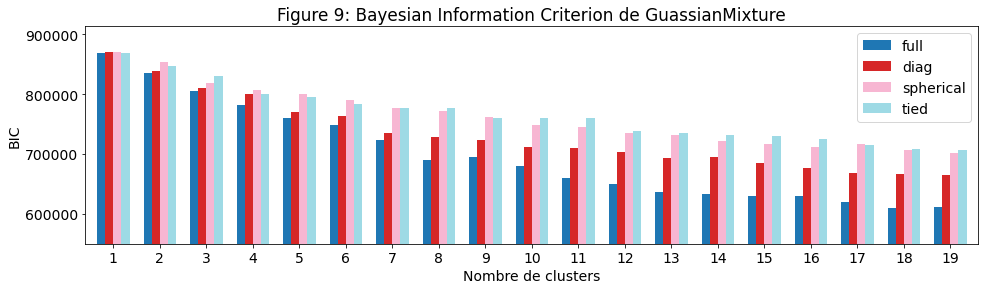

In [32]:
bic.plot.bar(figsize=(16,4), rot=0, ylim=550000, linewidth=1, width=0.7, cmap='tab20' )
pl.xlabel('Nombre de clusters')
pl.ylabel('BIC')
pl.title('Figure 9: Bayesian Information Criterion de GuassianMixture')

<font color='darkblue'><font size="3"> 
Nous choisissons la première valeur minimale que nous trouvons, n_components=7.
    
 <u>P.S:</u> Selon ce critère, plus le nombre de clusters est important, meilleur devrait être le modèle.
</font></font>

Text(0.5, 1.0, 'Figure 10: UMAP psychographique segmentation par GaussianMixture')

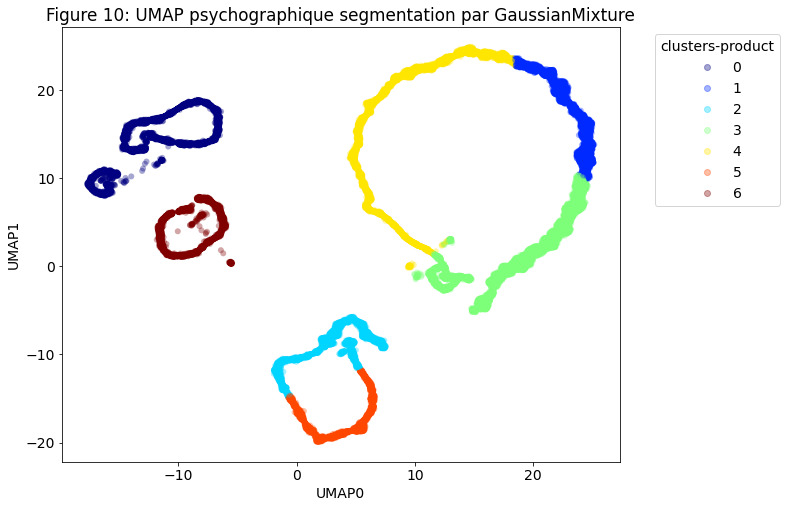

In [33]:
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sc = pl.scatter(data_UMAP[0], data_UMAP[1], c = GaussianMixture(n_components=7, covariance_type='full').fit_predict(data_UMAP), cmap = "jet", edgecolor = "None", alpha=0.35)
ax.legend(*sc.legend_elements(), title='clusters-product', bbox_to_anchor=(1.05, 1), loc='upper left')
pl.xlabel('UMAP0')
pl.ylabel('UMAP1')
pl.title('Figure 10: UMAP psychographique segmentation par GaussianMixture')

In [93]:
HCV_GMM = homogeneity_completeness_v_measure(y_product, GaussianMixture(n_components=7, covariance_type='full').fit_predict(data_UMAP))

Text(0.5, 1.0, 'Figure 11: UMAP psychographique segmentation par DBSCAN')

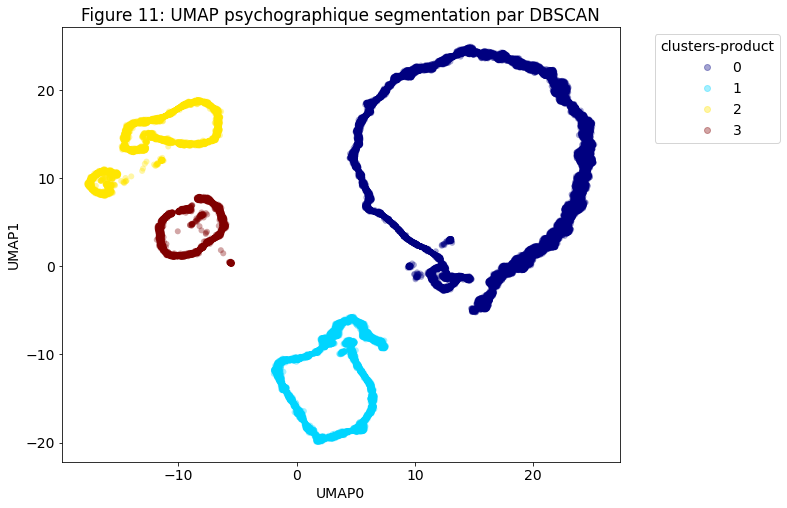

In [98]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=20).fit_predict(data_UMAP)

fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sc = pl.scatter(data_UMAP[0], data_UMAP[1], c = dbscan, cmap = "jet", edgecolor = "None", alpha=0.35)
ax.legend(*sc.legend_elements(), title='clusters-product', bbox_to_anchor=(1.05, 1), loc='upper left')
pl.xlabel('UMAP0')
pl.ylabel('UMAP1')
pl.title('Figure 11: UMAP psychographique segmentation par DBSCAN')

In [94]:
HCV_DB = homogeneity_completeness_v_measure(y_product, dbscan)

In [97]:
pd.DataFrame(np.column_stack([HCV_DB,HCV_GMM]), index=['homogeneity','completeness','v_measure'], columns =['GaussianMixture','DBSCAN'])

,GaussianMixture,DBSCAN
homogeneity,0.001909,0.015410
completeness,0.005624,0.026347
v_measure,0.002850,0.019446


#### C-3-3) Analyse
<font color='darkblue'><font size="3"> 
Dans cette partie, il est un peu difficile de faire une analyse des clients puisque nous avons fait une réduction de la dimension. Cette partie est utilisée uniquement pour faire du clustering sans dire quel client nous devrions cibler pour la proposition de contrat de maintenance. 
Maintenant, nous pouvons creuser un peu plus loin et compter les valeurs dans chaque cluster, choisir celui qui a le plus de valeurs et rechercher la catégorie du produit qui le relie à ce cluster. Par conséquent, nous pouvons cibler les clients avec la catégorie du produit.
</font></font>

## D) Meilleur cluster construit

<font color='darkblue'><font size="3"> 
Nous avons réalisé une segmentation de la clientèle suivant 3 critères très connus dans le monde du marketing (critères comportementaux, critères psychographiques, critères géographiques), et pour chaque critère nous avons présenté une ou deux méthodes de clustering. 
</font></font>

<font color='darkblue'><font size="3"> 
Parmi les trois clustering et les différentes méthodes, nous avons constaté que le RFM segmente parfaitement les clients, où nous pouvons visuellement distinguer la fidélité des clients et comprendre la distribution.
    
Parmi les " clustering du RFM, <b>RFM-4Means a les meilleures valeurs métriques, un temps de calcul minimum.</b>
</font></font>

<font color='darkblue'><font size="3"> 
<b>Le contrat de maintenance est:</b>
Le cluster 0 sont les clients pas fidèles.     
Cluster 1 représente les nouveaux clients, un suivi ciblé peut les convertir en clients réguliers. 
Cluster 2 ont été autrefois des clients fidèles mais ont cessé de l'être depuis. Un message ciblé peut les réactiver.   
Cluster 3 représente les clients qui ont souvent acheté et dépensé des sommes importantes, mais qui n'ont pas acheté récemment. Envoyez-leur des campagnes de réactivation personnalisées pour renouer le contact, et proposez des renouvellements et des produits utiles pour encourager un nouvel achat.
</font></font>

## E) Conclusion & perspectives

<font color='black'><font size="3">
* Nous avons testé plusieurs méthodes de clustering pour segmenter les clients d'Olist.
* Nous avons testé plusieurs critères de clustering, RFM, Géolocation, Psychographique.
* Nous avons présenté plusieurs possibilités pour gérer le cluster: Hyperparamétres, cross validation, train/test split, labels.
* Nous avons utilisé une "Distribution based method", "Centroid based clustering", "Density based clustering" and "hierarchical clustering".   
* Nous devrons recalculer RFM KMeans avec la répartition train/test et tester à nouveau avec d'autres méthodes de clustering.
* Nous pouvons aussi ne pas être limités par le clustering par Machine Learning, consultez la section suivante.    
</font></font>

## F) Annexe -- Clustering sans Machine Learning
<font color='darkblue'><font size="3"> 
Le clustering est un terme qui ne se limite pas seulement au Machine Leaning, nous pouvons par simple approche regrouper les clients. Voici deux clusters réalisés en quelques lignes et quelques secondes seulement.     
</font></font>    

<font color='darkblue'><font size="3"> 
Figure 1 du notebook précédent peut être considérée comme un clustering de géolocation parfait qui nous donne beaucoup d'informations en quelques clics.
</font></font>   

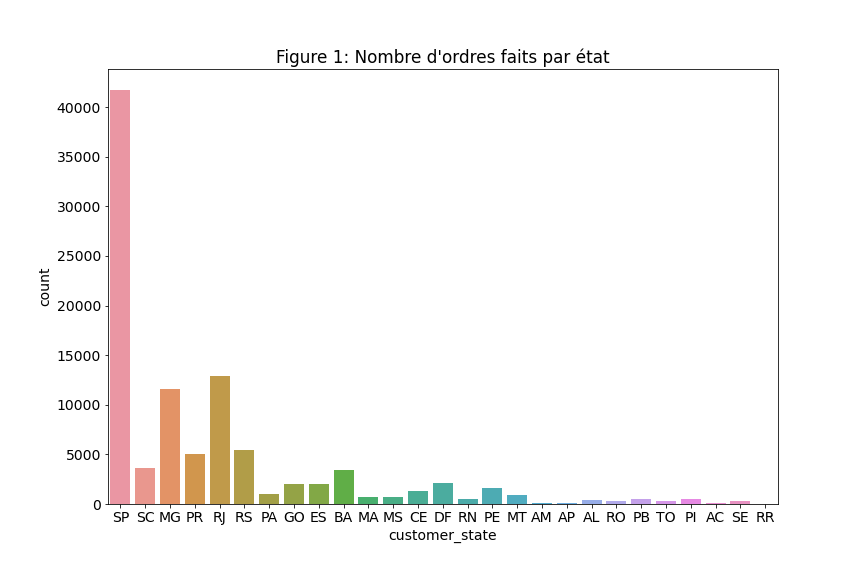

In [30]:
from IPython.display import Image
Image(filename='Figure1.png')

<font color='darkblue'><font size="3"> 
Nous pouvons également compliquer un peu le processus de clustering sans Machine Learning: 
</font></font>   

In [4]:
data_test = data
data_test['customer_zip'] =(data_test['customer_zip_code_prefix']/1000).astype(int)

data_groupby = data_test.groupby('customer_zip').agg({'customer_zip': lambda num: num.value_counts(),
                                       'review_score': lambda n: n.mean(),
                                       'price': lambda price: price.sum(),
                                       'payment_sequential':lambda k:k.mean()})
data_groupby.rename(index={'customer_zip': 'Code_departement'}, columns={'customer_zip': 'nombre_commande'},inplace=True)

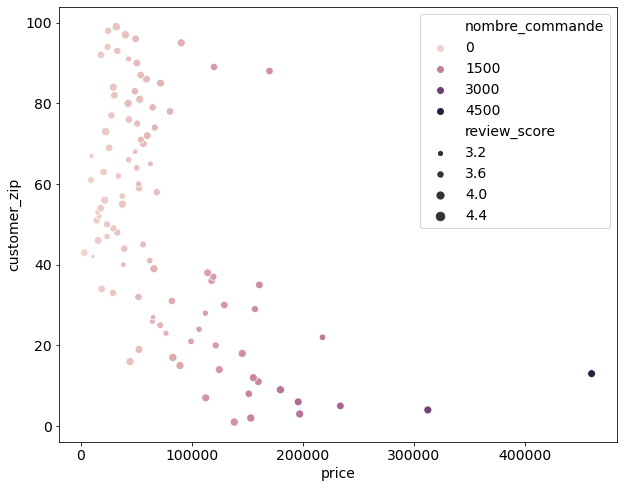

In [5]:
pl.figure(figsize=(10,8))
sn.scatterplot(x=data_groupby['price'], y=data_groupby.index,
               hue=data_groupby['nombre_commande'], size = data_groupby['review_score'])

In [7]:
data_groupby[data_groupby['price']>=300000.30000000005]

,nombre_commande,review_score,price,payment_sequential
customer_zip,,,,
4,2895,4.218307,312437.91,1.067703
13,3972,4.191591,459886.30,1.063948


,nombre_commande,review_score,price,payment_sequential
customer_zip,,,,
1,1125,4.292444,138151.62,1.033778
2,1396,4.273639,153076.80,1.067335
3,1752,4.246005,197105.79,1.075913
4,2895,4.218307,312437.91,1.067703
5,2062,4.125606,233702.85,1.077595
...,...,...,...,...
95,617,4.264182,90382.48,1.157212
96,400,4.112500,49306.39,1.055000
97,299,4.294314,40167.71,1.066890
